## CMIP6 soil moisture projections  
Computations to produce the CMIP6 results in Elling et al., 2025  
Data via Pangeo cloud optimized archive  
Pipeline adapted from http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html and http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/intake_ESM_example.html  

Note from author:  
This analysis pipeline is completely different from the core analysis, so scripts are kept separate  
Since cmip6 ensemble selection can be quite iterative and interactive, this analysis is done in a Jupyter notebook  
If using precomputed datasets from Zenodo, then start at Section 4  

## Table of contents (skip to section)
[1. Data loading](#1.-Load-data)  
[2. Model ensemble processing](#2.-Process-data)  
[3. Analysis](#3.-Data-analysis)  
[4. Jump right in](#4.-Get-a-headstart)  
[5. Figure](#5.-Figure)

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
dask.config.set(scheduler='threads', num_workers=2, memory_limit='4GB')
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle 
from matplotlib.ticker import FuncFormatter

import cmcrameri.cm as cmc

import rioxarray
import pandas as pd
import geopandas as gpd
import os

from shapely.affinity import rotate, translate
from shapely.geometry import Polygon
from shapely.geometry import mapping

import xesmf as xe

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.ndimage import gaussian_filter1d

import analysis_tools as atools

import sys
import scienceplots
import matplotlib as mpl
import warnings
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

/var/folders/yf/7rwdvk6x0d7g0551_s_xlt040000gn/T/ipykernel_49647/1336832393.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Load data

In [2]:
# get malawi shapefile, used for clipping data 
shapefile_path = 'data/shapefiles/mwi_admbnda_adm0_nso_hotosm_20230405.shp' # replace with your path if necessary
malawi_shape = gpd.read_file(shapefile_path) # malawi shape
mal_shape_buffered = gpd.GeoDataFrame(geometry=malawi_shape.buffer(1)).to_crs("EPSG:4326") # a 1 degree buffer works well to capture country bounds given the coarseness of climate models

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# These models are the only ones in the archive with mrsos diagnostic for hist, ssp245, ssp370, & ssp585 out to 2100
models_with_all_expts = ['ACCESS-CM2',
                         'BCC-CSM2-MR',
                         'CESM2-WACCM',
                         'CanESM5',
                         'CanESM5-CanOE',
                         'MIROC6',
                         'MPI-ESM1-2-HR',
                         'MPI-ESM1-2-LR',
                         'UKESM1-0-LL']

# subset for model experiment IDs and surface soil moisture variable mrsos
cat = col.search(experiment_id=['historical', 'ssp245', 'ssp370', 'ssp585'], table_id='Lmon', variable_id='mrsos',
                 grid_label='gn',
                source_id = models_with_all_expts
                )

dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})

# rg query
rg_query = dict(experiment_id=['historical', 'ssp245', 'ssp370', 'ssp585'], table_id='Lmon', variable_id='mrsos',
                 grid_label='gn',
                source_id = models_with_all_expts
               )

rg_cat = col.search(**rg_query)
rg_dset_dict = rg_cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## 2. Process data

In [4]:
# functions 
def regrid(ds_in, regrid_to, method='bilinear'):
    '''regrid data to common grid'''
    
    regridder = xe.Regridder(ds_in, regrid_to, method=method, periodic=True, ignore_degenerate=True)
    ds_out = regridder(ds_in)
    return ds_out


def sorted_split_list(a_list):
    '''sort runs by experiment to get model keys'''
    
    hist_list = []
    ssp245_list = []
    ssp370_list = []
    ssp585_list = []
    for item in a_list:
        if 'historical' in item:
            hist_list.append(item)
        elif 'ssp245' in item:
            ssp245_list.append(item)
        elif 'ssp370' in item:
            ssp370_list.append(item)
        elif 'ssp585' in item:
            ssp585_list.append(item)
        else: print('Could not find experiment name in key:'+item)
    return sorted(hist_list), sorted(ssp245_list), sorted(ssp370_list), sorted(ssp585_list)


def get_malawi(ds, mal_shape_buffered, y1, y2):
    '''clip data around Malawi, more precise than a rectangular mask'''
    
    ds = ds.sel(time=slice(y1, y1)).mean("time")   
    ds = dset_dict[key].squeeze()   
    ds = regrid(ds, rg_ds, method='conservative').mrsos
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    # get grid cells in malawi and get time mean over selected period
    ds_mal = ds.rio.clip(mal_shape_buffered.geometry.apply(mapping), mal_shape_buffered.crs, drop=True) # clip ds by district bound
    return ds_mal


def get_malawi_timeseries(ds, mal_shape_buffered):
    '''same as above, but for timeseries analysis'''
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    # get grid cells in malawi and get time mean over selected period
    ds_mal = ds.rio.clip(mal_shape_buffered.geometry.apply(mapping), mal_shape_buffered.crs, drop=True) # clip ds by district bounds
    return ds_mal

now regrid the data to common grid  
we get two sets: time-averaged datasets and time series (area-averaged) datasets

In [5]:
# extract model keys
hist_keys, ssp245_keys, ssp370_keys, ssp585_keys = sorted_split_list(list(dset_dict.keys()))

# CESM2-WACCM used as target grid
rg_ds = rg_dset_dict['ScenarioMIP.NCAR.CESM2-WACCM.ssp370.Lmon.gn'].isel(time=0).drop_vars("time").squeeze()

# doesn't take too long, so leaving inefficient nested loop for now. revisit later
ds_regrid_dict_hist = dict()
ds_regrid_dict_ssp245 = dict()
ds_regrid_dict_ssp370 = dict()
ds_regrid_dict_ssp585 = dict()
regrid_dicts = [ds_regrid_dict_hist, ds_regrid_dict_ssp245, ds_regrid_dict_ssp370, ds_regrid_dict_ssp585]

ds_ts_dict_hist = dict()
ds_ts_dict_ssp245 = dict()
ds_ts_dict_ssp370 = dict()
ds_ts_dict_ssp585 = dict()
ts_dicts = [ds_ts_dict_hist, ds_ts_dict_ssp245, ds_ts_dict_ssp370, ds_ts_dict_ssp585]

success_count_regrid = 0
success_count_ts = 0
model_count = 0

for expt_keys, regrid_dict, ts_dict in zip(
    [hist_keys, ssp245_keys, ssp370_keys, ssp585_keys],
    regrid_dicts,
    ts_dicts
):
    for key in expt_keys:
        model = key.split('.')[2]
        try:
            ds = dset_dict[key].squeeze()

            # do spatial data processing
            if "historical" in key:
                ds_mal_regrid = get_malawi(ds, mal_shape_buffered, "1980", "2014") # historical period used in study
            else:
                ds_mal_regrid = get_malawi(ds, mal_shape_buffered, "2066", "2100") # future period used in study
            ds_mal_mrsos_regridded = ds_mal_regrid.copy()

            # keep whole time series (later will average)
            ds_mal_ts = get_malawi_timeseries(ds, mal_shape_buffered)
            ds_mal_mrsos_tsded = ds_mal_ts.copy()

        except Exception as e:
            print('Failed for '+model+': '+str(e))
        else:
            regrid_dict[model] = ds_mal_mrsos_regridded
            ts_dict[model] = ds_mal_mrsos_tsded
            print(model+' regridded and tsded and added to dictionaries')
            success_count_regrid += 1
            success_count_ts += 1
        finally:
            model_count += 1

    print('-'*40)
    print(f'| {success_count_regrid}/{model_count} models successfully regridded! |')
    print(f'| {success_count_ts}/{model_count} models successfully tsed!       |')
    print('-'*40)


BCC-CSM2-MR regridded and tsded and added to dictionaries
CanESM5-CanOE regridded and tsded and added to dictionaries
CanESM5 regridded and tsded and added to dictionaries
ACCESS-CM2 regridded and tsded and added to dictionaries
MIROC6 regridded and tsded and added to dictionaries
UKESM1-0-LL regridded and tsded and added to dictionaries
MPI-ESM1-2-HR regridded and tsded and added to dictionaries
MPI-ESM1-2-LR regridded and tsded and added to dictionaries
CESM2-WACCM regridded and tsded and added to dictionaries
----------------------------------------
| 9/9 models successfully regridded! |
| 9/9 models successfully tsed!       |
----------------------------------------
BCC-CSM2-MR regridded and tsded and added to dictionaries
CanESM5-CanOE regridded and tsded and added to dictionaries
CanESM5 regridded and tsded and added to dictionaries
ACCESS-CM2 regridded and tsded and added to dictionaries
MPI-ESM1-2-HR regridded and tsded and added to dictionaries
MIROC6 regridded and tsded and a

In [9]:
# tidy up datasets, get em, etc
ds_hist_ts_all = []
ds_ssp245_ts_all = []
ds_ssp370_ts_all = []
ds_ssp585_ts_all = []
ts_all_lists = [ds_hist_ts_all, ds_ssp245_ts_all, ds_ssp370_ts_all, ds_ssp585_ts_all]
# get dummy time array to make all the datasets consistent calendar
hist_time_dummy = ts_dicts[0]['BCC-CSM2-MR'].time.convert_calendar("noleap").sel(time=slice("1850", "2014")).time.values
ssp_time_dummy = ts_dicts[1]['BCC-CSM2-MR'].time.convert_calendar("noleap").sel(time=slice("2015", "2100")).time.values

ds_hist_all = []
ds_ssp245_all = []
ds_ssp370_all = []
ds_ssp585_all = []
regrid_all_lists = [ds_hist_all, ds_ssp245_all, ds_ssp370_all, ds_ssp585_all]

for ts_dict, regrid_dict, ts_all, regrid_all in zip(ts_dicts, regrid_dicts, ts_all_lists, regrid_all_lists):

    # process timeseries dicts
    for d in list(ts_dict.values()):
        if d.time.dt.year.min() == 1850:
            d = d.sel(time=slice("1850", "2014"))
            exptype = "historical"
        elif d.time.dt.year.min() == 2015:
            d = d.sel(time=slice("2015", "2100"))
            exptype = "ssp"
        else:
            print(f"!! Check time range on ds: \n{d}")
            continue
        try:
            if exptype == "historical":
                d['time'] = hist_time_dummy
            elif exptype == "ssp":
                d['time'] = ssp_time_dummy
        except:
            d['time'] = d.time.convert_calendar("noleap")
        if "member_id" in d.dims:
            d = d.mean("member_id")  # ensemble mean for each model
        if "member_id" in d.coords:
            d = d.drop_vars("member_id")
        if "depth" in d.coords:
            ts_all.append(d.drop_vars("depth"))
        else:
            ts_all.append(d)

    # process spatial dicts
    for d in list(regrid_dict.values()):
        d = d.sel(time=slice("1850", "2100"))
        d["time"] = d.indexes["time"].to_datetimeindex()
        if "member_id" in d.dims:
            d = d.mean("member_id")  # ensemble mean for each model
        if "member_id" in d.coords:
            d = d.drop_vars("member_id")
        if "depth" in d.coords:
            regrid_all.append(d.drop_vars("depth"))
        else:
            regrid_all.append(d)

now combine into one dataset per experiment. Do time series ds first...

In [10]:
# get dummy time array to make all the datasets consistent calendar
hist_time_dummy = ts_dicts[0]['BCC-CSM2-MR'].time.convert_calendar("noleap").sel(time=slice("1850", "2014")).time.values
ssp_time_dummy = ts_dicts[1]['BCC-CSM2-MR'].time.convert_calendar("noleap").sel(time=slice("2015", "2100")).time.values

# concatenate datasets along time 
coord_hist = list(ds_ts_dict_hist.keys())
ds_out_ts_hist = xr.concat(objs=ds_hist_ts_all, dim=coord_hist, coords='all').rename({'concat_dim':'model'})
coord_ssp245 = list(ds_ts_dict_ssp245.keys())
ds_out_ts_ssp245 = xr.concat(objs=ds_ssp245_ts_all, dim=coord_ssp245, coords='all').rename({'concat_dim':'model'})
coord_ssp370 = list(ds_ts_dict_ssp370.keys())
ds_out_ts_ssp370 = xr.concat(objs=ds_ssp370_ts_all, dim=coord_ssp370, coords='all').rename({'concat_dim':'model'})
coord_ssp585 = list(ds_ts_dict_ssp585.keys())
ds_out_ts_ssp585 = xr.concat(objs=ds_ssp585_ts_all, dim=coord_ssp585, coords='all').rename({'concat_dim':'model'})

# get spatial average
ds_out_ts_hist_mean = atools.area_weighted_mean(ds_out_ts_hist, (-90, 90), (0, 360))
ds_out_ts_ssp245_mean = atools.area_weighted_mean(ds_out_ts_ssp245, (-90, 90), (0, 360))
ds_out_ts_ssp370_mean = atools.area_weighted_mean(ds_out_ts_ssp370, (-90, 90), (0, 360))
ds_out_ts_ssp585_mean = atools.area_weighted_mean(ds_out_ts_ssp585, (-90, 90), (0, 360))

and now spatial ds...

In [11]:
# concat datasets 
coord_hist = list(ds_regrid_dict_hist.keys())
ds_out_regrid_hist = xr.concat(objs=ds_hist_all, dim=coord_hist, coords='all').rename({'concat_dim':'model'})

coord_ssp245 = list(ds_regrid_dict_ssp245.keys())
ds_out_regrid_ssp245 = xr.concat(objs=ds_ssp245_all, dim=coord_ssp245, coords='all').rename({'concat_dim':'model'})

coord_ssp370 = list(ds_regrid_dict_ssp370.keys())
ds_out_regrid_ssp370 = xr.concat(objs=ds_ssp370_all, dim=coord_ssp370, coords='all').rename({'concat_dim':'model'})

coord_ssp585 = list(ds_regrid_dict_ssp585.keys())
ds_out_regrid_ssp585 = xr.concat(objs=ds_ssp585_all, dim=coord_ssp585, coords='all').rename({'concat_dim':'model'})

## 3. Data analysis

In [ ]:
# load these data into memory so we don't have to recompute every plot
ds_out_regrid_hist = ds_out_regrid_hist.compute()
ds_out_regrid_ssp245 = ds_out_regrid_ssp245.compute()
ds_out_regrid_ssp370 = ds_out_regrid_ssp370.compute()
ds_out_regrid_ssp585 = ds_out_regrid_ssp585.compute()
historical_ts = ds_out_ts_hist_mean.compute()
ssp245_ts = ds_out_ts_ssp245_mean.compute()
ssp370_ts = ds_out_ts_ssp370_mean.compute()
ssp585_ts = ds_out_ts_ssp585_mean.compute()

# save these processed datasets, so we do not have to re-calculate in the future
ds_out_regrid_hist.to_netcdf("preprocessed/soil_ds_out_regrid_hist.nc")
ds_out_regrid_ssp245.to_netcdf("preprocessed/soil_ds_out_regrid_ssp245.nc")
ds_out_regrid_ssp370.to_netcdf("preprocessed/soil_ds_out_regrid_ssp370.nc")
ds_out_regrid_ssp585.to_netcdf("preprocessed/soil_ds_out_regrid_ssp585.nc")
ds_out_ts_hist_mean.to_netcdf("preprocessed/historical_ts.nc")
ds_out_ts_ssp245_mean.to_netcdf("preprocessed/ssp245_ts.nc")
ds_out_ts_ssp370_mean.to_netcdf("preprocessed/ssp370_ts.nc")
ds_out_ts_ssp585_mean.to_netcdf("preprocessed/ssp585_ts.nc")

## 4. Get a headstart  
if using preprocessed data, start here

In [18]:
# NOTE: if you have pulled the preprocessed data from Zenodo, then START HERE
ds_out_regrid_hist = xr.open_dataset("preprocessed/soil_ds_out_regrid_hist.nc").mrsos
ds_out_regrid_ssp245 = xr.open_dataset("preprocessed/soil_ds_out_regrid_ssp245.nc").mrsos
ds_out_regrid_ssp370 = xr.open_dataset("preprocessed/soil_ds_out_regrid_ssp370.nc").mrsos
ds_out_regrid_ssp585 = xr.open_dataset("preprocessed/soil_ds_out_regrid_ssp585.nc").mrsos

historical_ts = xr.open_dataset("preprocessed/historical_ts.nc")
ssp245_ts = xr.open_dataset("preprocessed/ssp245_ts.nc").sel(time=slice("2015", "2100"))
ssp370_ts = xr.open_dataset("preprocessed/ssp370_ts.nc").sel(time=slice("2015", "2100"))
ssp585_ts = xr.open_dataset("preprocessed/ssp585_ts.nc").sel(time=slice("2015", "2100"))

In [24]:
# get key statistics
em_hist = ds_out_regrid_hist.mean("model").mean("time")
em_ssp245 = ds_out_regrid_ssp245.mean("model").mean("time")
em_ssp370 = ds_out_regrid_ssp370.mean("model").mean("time")
em_ssp585 = ds_out_regrid_ssp585.mean("model").mean("time")
# differences in future minus historical
diff_ssp245 = (ds_out_regrid_ssp245.mean("time") - ds_out_regrid_hist.mean("time"))
diff_ssp370 = (ds_out_regrid_ssp370.mean("time") - ds_out_regrid_hist.mean("time"))
diff_ssp585 = (ds_out_regrid_ssp585.mean("time") - ds_out_regrid_hist.mean("time"))

diff_ssp245_em = diff_ssp245.mean('model')
diff_ssp370_em = diff_ssp370.mean('model')
diff_ssp585_em = diff_ssp585.mean('model')

# get annual means for ts
hist = historical_ts.resample(time="1YE").mean()
ssp245 = ssp245_ts.resample(time="1YE").mean()
ssp370 = ssp370_ts.resample(time="1YE").mean()
ssp585 = ssp585_ts.resample(time="1YE").mean()

some plotting functions

In [28]:
# Plotting functions for timeseries plot
def smooth_gauss_model(da):
    '''apply smoothing to da on dim model'''
    da_sm = gaussian_filter1d(da, 2)
    return da_sm
# # Function to plot ensemble mean and 95% CI
def plot_with_ci(data, label_prefix, color, linestyle="-", zorder=1):
    '''smooth timeseries to get low-frequency signal'''
    smoothed_da = data['mrsos'].groupby('model').apply(
    lambda grp: xr.apply_ufunc(
        smooth_gauss_model,
        grp,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='allowed')
    )
    
    # get EM
    ensemble_mean = smoothed_da.mean(dim="model")
    
    # get 95% CI
    ci_lower = smoothed_da.quantile(0.025, dim="model")
    ci_upper = smoothed_da.quantile(0.975, dim="model")
    
    # ensemble mean solid line
    ensemble_mean.plot(label=f"{label_prefix} Mean", color=color, linestyle=linestyle, linewidth=2, zorder=zorder)
    
    # fill between 95% CI
    plt.fill_between(
        ensemble_mean.time.values,
        ci_lower.values,
        ci_upper.values,
        color=color,
        alpha=0.1,
        label=f"{label_prefix} 95% CI",
        zorder=zorder-1
    )

# cosmetic plotting bug fix: fix degrees label bug on map
def format_lon(x, pos=None):
    if x == 0:
        return "0"
    return f"{abs(int(x))}{'E' if x > 0 else 'W'}"

def format_lat(y, pos=None):
    if y == 0:
        return "0"
    return f"{abs(int(y))}{'N' if y > 0 else 'S'}"

def plot_soil_moisture_multipanel(diff_ssp245, diff_ssp370, diff_ssp585, historical_ts, ssp245_ts, ssp370_ts, ssp585_ts, malawi_shape, plot_with_ci, figname, frac_agree=0.8):
    '''big function for multipanel plot with grid hatching where >X% models agree on sign of change'''   
    with plt.style.context('science'):
        plt.style.use(['no-latex'])
        
        fig = plt.figure(figsize=(10, 12))
        
        # Top row subplots with shared colorbar
        gs = fig.add_gridspec(2, 4, height_ratios=[1, 0.8], width_ratios=[1, 1, 1, 0.05], hspace=0.2, wspace=0.01)
        
        # a) SSP245
        ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
        ax1.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
        
        diff_em = diff_ssp245.mean("model")
        signs = xr.apply_ufunc(np.sign, diff_ssp245)
        pos_agree = (signs == 1).sum(dim='model')
        neg_agree = (signs == -1).sum(dim='model')
        total_models = diff_ssp245.sizes['model']
        max_agree = xr.ufuncs.maximum(pos_agree, neg_agree)
        agreement_mask = max_agree / total_models >= frac_agree
        hatch_mask = agreement_mask.where(agreement_mask, other=np.nan)
        
        # hatch grid cells where > threshold % of models agree on sign of change
        lonmg, latmg = np.meshgrid(hatch_mask.lon, hatch_mask.lat)
        lonscatter, latscatter = [], []
        for i in np.arange(0, len(latmg), 1):
            for j in np.arange(0, len(lonmg[0]), 1):
                if hatch_mask[i, j] == 1:
                    lonscatter.append(lonmg[i, j])
                    latscatter.append(latmg[i, j])
        
        width = 1.2
        height = 0.9
        
        for lon, lat in zip(lonscatter, latscatter):
            rect = Rectangle((lon - width/2, lat - height/2), width, height,
                             linewidth=0, edgecolor='black', facecolor='none', hatch='////', alpha=0.5,
                             transform=ccrs.PlateCarree(), zorder=2)
            ax1.add_patch(rect)
        
        malawi_shape.plot(ax=ax1, facecolor="None", edgecolor="black",
                          linewidth=1, transform=ccrs.PlateCarree(), zorder=2)
        
        im1 = diff_em.plot(ax=ax1, cmap=cmc.roma, vmin=-2, vmax=2,
                           transform=ccrs.PlateCarree(), add_colorbar=False)
        gl = ax1.gridlines(draw_labels=True, linewidth=0)
        gl.xformatter = FuncFormatter(format_lon)
        gl.yformatter = FuncFormatter(format_lat)
        gl.right_labels = []
        gl.top_labels = []
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        
        ax1.set_title("a) SSP245", fontsize=18, weight='bold', loc='left')
        ax1.axis('off')
        
        # b) SSP370
        ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
        ax2.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
        
        diff_em = diff_ssp370.mean("model")
        signs = xr.apply_ufunc(np.sign, diff_ssp370)
        pos_agree = (signs == 1).sum(dim='model')
        neg_agree = (signs == -1).sum(dim='model')
        total_models = diff_ssp370.sizes['model']
        max_agree = xr.ufuncs.maximum(pos_agree, neg_agree)
        agreement_mask = max_agree / total_models >= frac_agree
        hatch_mask = agreement_mask.where(agreement_mask, other=np.nan)

        # hatch grid cells where > threshold % of models agree on sign of change
        lonmg, latmg = np.meshgrid(hatch_mask.lon, hatch_mask.lat)
        lonscatter, latscatter = [], []
        for i in np.arange(0, len(latmg), 1):
            for j in np.arange(0, len(lonmg[0]), 1):
                if hatch_mask[i, j] == 1:
                    lonscatter.append(lonmg[i, j])
                    latscatter.append(latmg[i, j])
        
        for lon, lat in zip(lonscatter, latscatter):
            rect = Rectangle((lon - width/2, lat - height/2), width, height,
                             linewidth=0, edgecolor='black', facecolor='none', hatch='////', alpha=0.5,
                             transform=ccrs.PlateCarree(), zorder=2)
            ax2.add_patch(rect)
        
        malawi_shape.plot(ax=ax2, facecolor="None", edgecolor="black",
                          linewidth=1, transform=ccrs.PlateCarree(), zorder=2)
        
        diff_em.plot(ax=ax2, cmap=cmc.roma, vmin=-2, vmax=2,
                     transform=ccrs.PlateCarree(), add_colorbar=False)

        gl = ax2.gridlines(draw_labels=True, linewidth=0)
        gl.xformatter = FuncFormatter(format_lon)
        gl.yformatter = FuncFormatter(format_lat)
        gl.right_labels = []
        gl.left_labels = []
        gl.top_labels = []
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        
        ax2.set_title("b) SSP370", fontsize=18, weight='bold', loc='left')
        ax2.axis('off')
        
        # c) SSP585
        ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
        ax3.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
        
        diff_em = diff_ssp585.mean("model")
        signs = xr.apply_ufunc(np.sign, diff_ssp585)
        pos_agree = (signs == 1).sum(dim='model')
        neg_agree = (signs == -1).sum(dim='model')
        total_models = diff_ssp585.sizes['model']
        max_agree = xr.ufuncs.maximum(pos_agree, neg_agree)
        agreement_mask = max_agree / total_models >= frac_agree
        hatch_mask = agreement_mask.where(agreement_mask, other=np.nan)
        
        # hatch grid cells where > threshold % of models agree on sign of change
        lonmg, latmg = np.meshgrid(hatch_mask.lon, hatch_mask.lat)
        lonscatter, latscatter = [], []
        for i in np.arange(0, len(latmg), 1):
            for j in np.arange(0, len(lonmg[0]), 1):
                if hatch_mask[i, j] == 1:
                    lonscatter.append(lonmg[i, j])
                    latscatter.append(latmg[i, j])
        
        for lon, lat in zip(lonscatter, latscatter):
            rect = Rectangle((lon - width/2, lat - height/2), width, height,
                             linewidth=0, edgecolor='black', facecolor='none', hatch='////', alpha=0.5,
                             transform=ccrs.PlateCarree(), zorder=2)
            ax3.add_patch(rect)
        
        malawi_shape.plot(ax=ax3, facecolor="None", edgecolor="black",
                          linewidth=1, transform=ccrs.PlateCarree(), zorder=2)
        
        diff_em.plot(ax=ax3, cmap=cmc.roma, vmin=-2, vmax=2,
                     transform=ccrs.PlateCarree(), add_colorbar=False)

        gl = ax3.gridlines(draw_labels=True, linewidth=0)
        gl.xformatter = FuncFormatter(format_lon)
        gl.yformatter = FuncFormatter(format_lat)
        gl.right_labels = []
        gl.left_labels = []
        gl.top_labels = []
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        
        ax3.set_title("c) SSP585", fontsize=18, weight='bold', loc='left')
        ax3.axis('off')
        
        # Shared colorbar
        cax = fig.add_subplot(gs[0, 3])
        cbar = plt.colorbar(im1, cax=cax, orientation='vertical', pad=0.01)
        cbar.set_label("kg/$m^2$", rotation=270, fontsize=14, labelpad=15)
        cbar.ax.tick_params(labelsize=14)
        
        # d) Time series
        ax4 = fig.add_subplot(gs[1, :3])
        
        hist_ts_base = historical_ts.sel(time=slice("1850", "1899")).mean("time")
        hist_change = (100*(historical_ts.sel(time=slice("1980", "2014")) - hist_ts_base)/hist_ts_base).resample(time="1YE").mean()
        ssp245_change = (100*(ssp245_ts - hist_ts_base)/hist_ts_base).resample(time="1YE").mean()
        ssp370_change = (100*(ssp370_ts - hist_ts_base)/hist_ts_base).resample(time="1YE").mean()
        ssp585_change = (100*(ssp585_ts - hist_ts_base)/hist_ts_base).resample(time="1YE").mean()
        
        plot_with_ci(hist_change, "historical", "gray", linestyle="-", zorder=5)
        plot_with_ci(ssp245_change, "SSP245", "#F4A300", linestyle="-", zorder=4)
        plot_with_ci(ssp370_change, "SSP370", "#E4572E", linestyle="-", zorder=3)
        plot_with_ci(ssp585_change, "SSP585", "#7209B7", linestyle="-", zorder=2)
        
        plt.axhline(0, color="gray", linestyle="--", linewidth=0.8, zorder=1, alpha=0.7)
        plt.tick_params(axis='both', labelsize=14)
        plt.ylim(-40, 20)
        plt.legend(loc="upper right", fontsize=11.5, ncol=4, frameon=False)
        plt.title("d) Projected change in surface soil moisture from 1850-1899", fontsize=18, weight='bold', loc='left')
        plt.ylabel("% change", size=14)
        plt.xlabel(None)
        
        plt.tight_layout()
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.show()


## 5. Figure

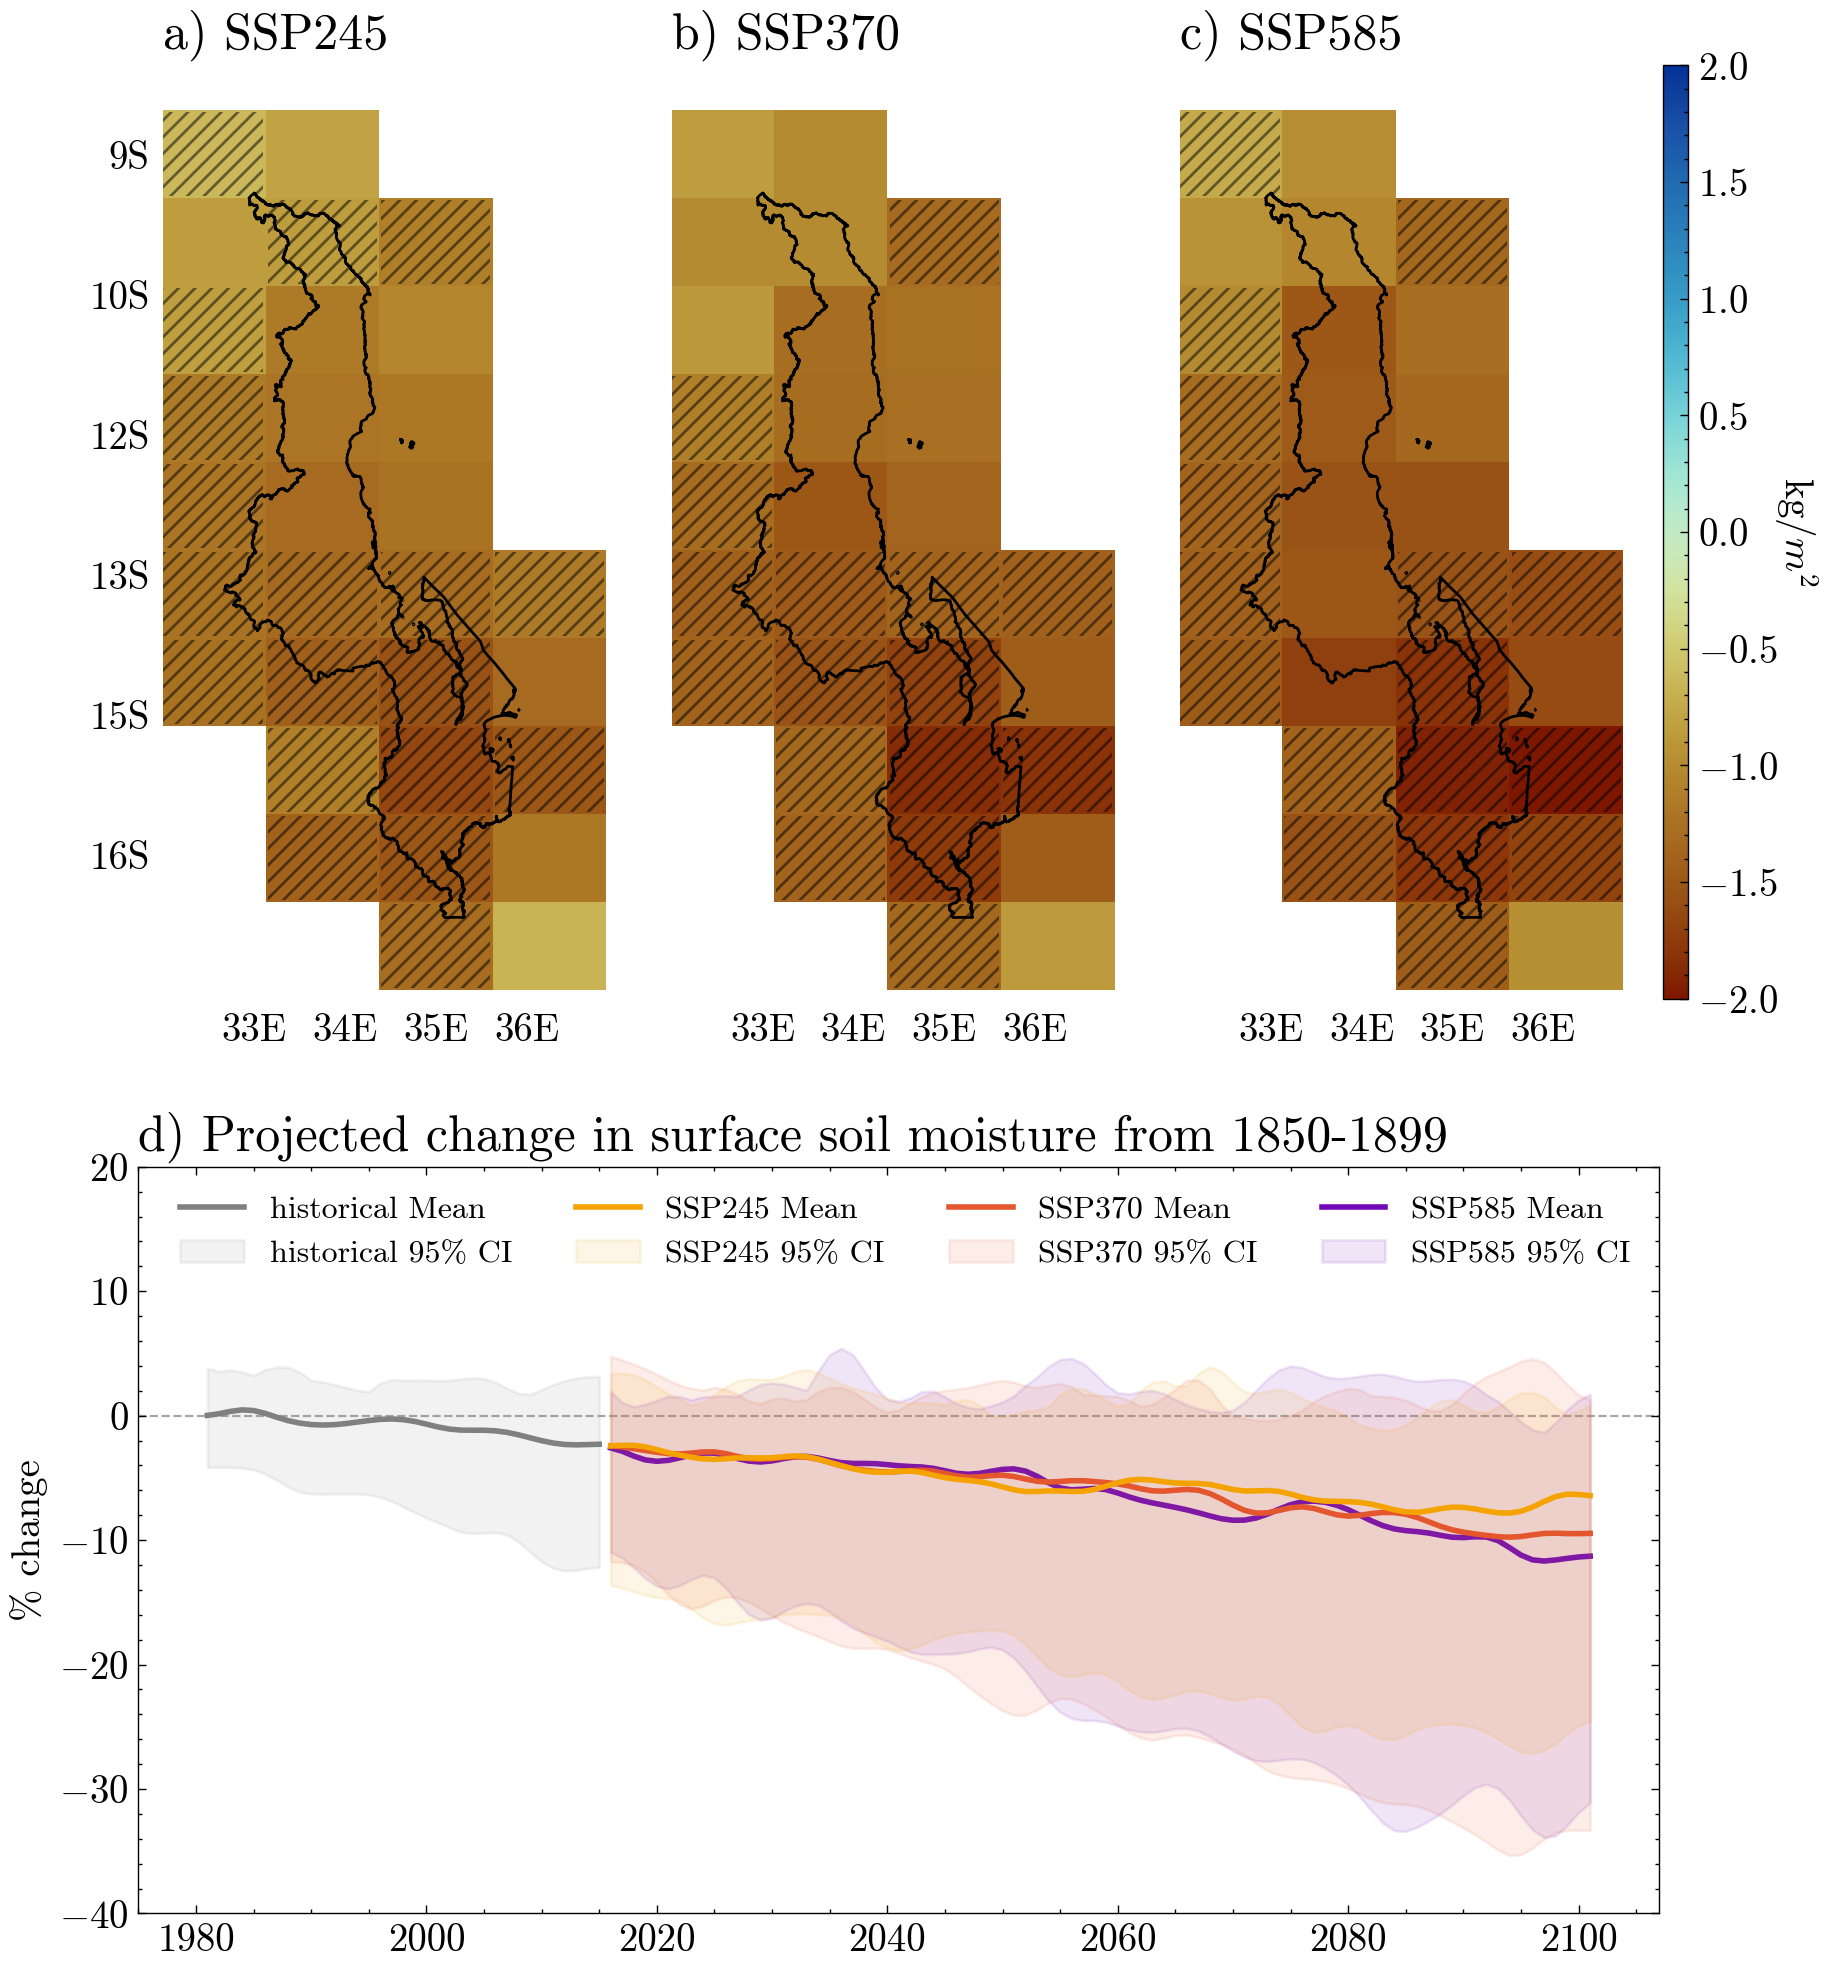

In [30]:
# plot it - Figure 7 
frac_agree = 0.8 # % of models that must agree on the sign of change for the grid cells to be hatched
outpath = "path-to-your-figure.png"
plot_soil_moisture_multipanel(diff_ssp245, diff_ssp370, diff_ssp585, historical_ts, ssp245_ts, ssp370_ts, ssp585_ts, malawi_shape, plot_with_ci, figname=outpath)